In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import os

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [4]:
with open('Data/Data12/GB_result_12I1O.pkl', 'rb') as f:
    result = pickle.load(f)

In [5]:
df_r = pd.DataFrame(result)

In [6]:
r2 = df_r[3].apply(pd.Series)

The below graph shows how R<sup>2</sup> and RMSE change throughout each iteration. "Iteration 0" is the basic DEA without any constarints while the other iterations have constraints extracted from ML feature importance.

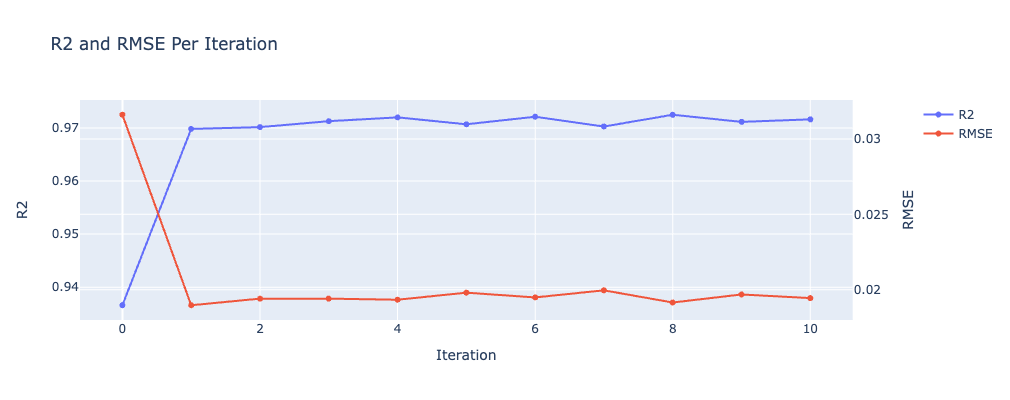

In [7]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(go.Scatter(y =  r2.r2, x = r2.index, name = "R2"),  secondary_y=False)
fig.add_trace(go.Scatter(y =  r2.neg_root_mean_squared_error * -1, x = r2.index, name = "RMSE"), secondary_y=True)


fig.update_layout(title="R2 and RMSE Per Iteration",
                    xaxis_title='Iteration',
                    yaxis_title='R2',
                    yaxis2_title='RMSE',
                   autosize=False,
                   width=700,
                  height=400,
                 )
fig.update_layout(title_text = "R2 and RMSE Per Iteration")

fig.show()

The below graph shows how zero counts change throughout each iteration.

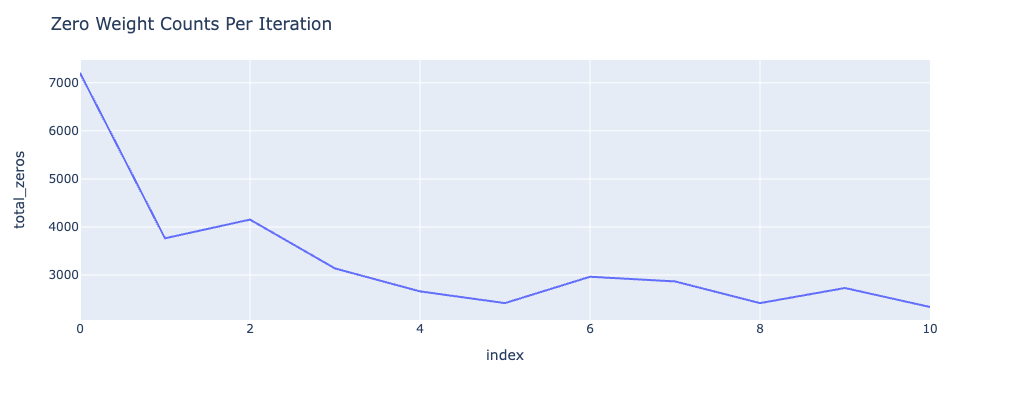

In [8]:
fig = px.line(r2, x=r2.index, y=r2.total_zeros)

fig.update_layout(
    autosize=False,
    width=700,
    height=400,
    title_text=f"Zero Weight Counts Per Iteration",
)

fig.show()

In [9]:
df_imp = pd.read_pickle('Data/Data12/GB_12I1O_df_imp.pkl')

In [10]:
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.579320  Output 01           0          0
1       Input 01    0.064559   Input 01         330          0
2       Input 08    0.056970   Input 08         428          0
3       Input 03    0.048775   Input 03         249          0
4       Input 09    0.045691   Input 09         599          0
..           ...         ...        ...         ...        ...
138     Input 10    0.005973   Input 10         166         10
139     Input 11    0.005259   Input 11         175         10
140     Input 02    0.003949   Input 02         813         10
141     Input 08    0.003193   Input 08         196         10
142     Input 03    0.002627   Input 03         278         10

[143 rows x 5 columns]

The below bar graph shows how feature importance of Inputs and Output change throughout each iteration.

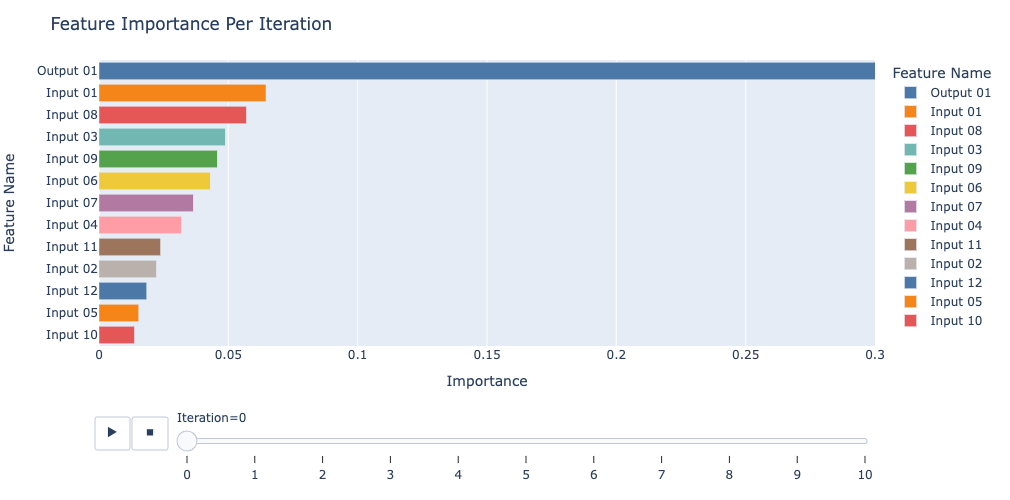

In [11]:
fig = px.bar(
    df_imp,
    y="Feature Name",
    x="Importance",
    color="Feature Name",
    color_discrete_sequence=px.colors.qualitative.T10,
    animation_frame="Iteration",
    animation_group="Feature Name",
    orientation="h",
    range_x=[0,0.3]
)

fig.update_yaxes(categoryorder='total ascending')

fig.update_layout(
    autosize=False,
    width=700,
    height=500,
    title_text=f"Feature Importance Per Iteration",
)


fig.show()

The below line graph shows how feature importance of Inputs and Output change throughout each iteration.

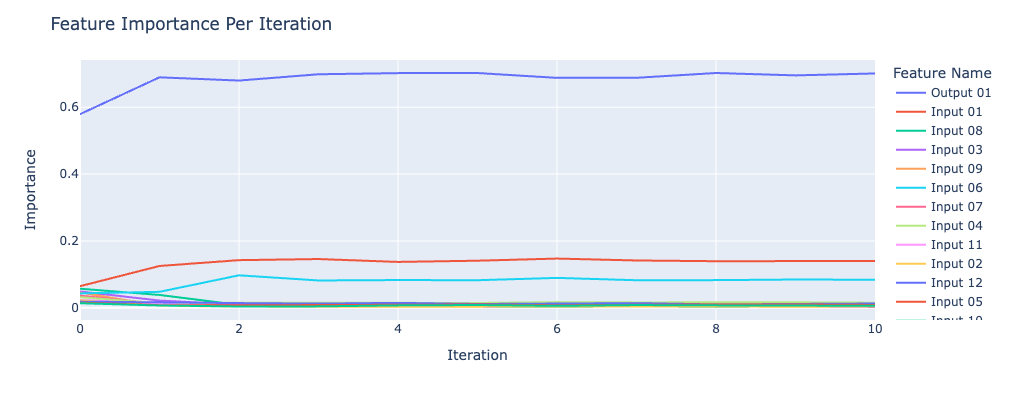

In [12]:
fig = px.line(df_imp, x='Iteration', y="Importance", color = "Feature Name")

fig.update_layout(
    autosize=False,
    width=700,
    height=400,
    title_text=f"Feature Importance Per Iteration",
)

fig.show()

In [13]:
folder = "Data/Data12/"

In [14]:
files_es = sorted([f for f in os.listdir(folder) if os.path.splitext(f)[1]==".xlsx" if "gradientboostingregressor" in f], key = lambda x: len(x))
files_es = ["US12I1O_Sol_0.xlsx"] + sorted(files_es[:-1]) + [files_es[-1]]

In [15]:
df_es = pd.DataFrame()

for i, f in enumerate(files_es):
    df_temp = pd.read_excel(folder + f, index_col=0, usecols="A:B")
    n = os.path.splitext(f)[0][-1] if i!=10 else os.path.splitext(f)[0][-2:]
    df_temp.columns = [f"{n}"]
    df_es = pd.concat([df_es, df_temp], axis=1)

The below line graph shows how Efficiency Score of DMUs changes per iteration. You can use dropdown menu on the right upper corner to change DMU group.

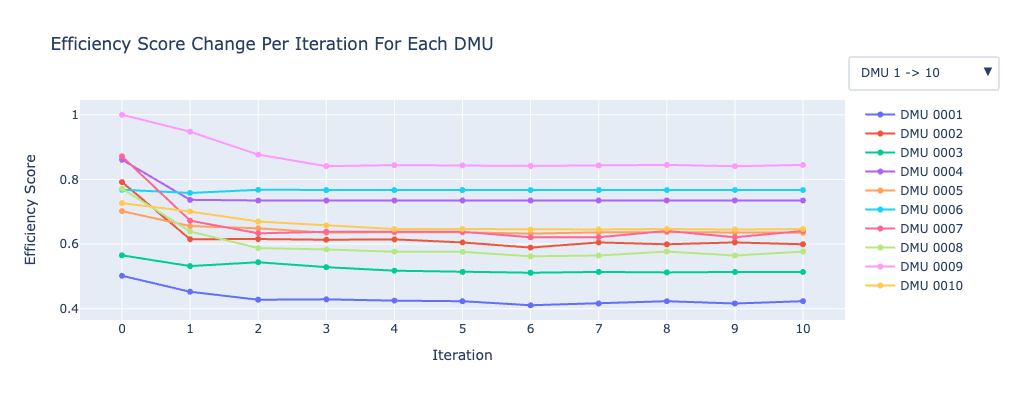

In [17]:
default_dmu_group = 1

# dd=go.Figure()

dd = go.Figure()
buttons=[]
plot_names = list(range(1,1001))


for ind in range(1,1001, 10):
    
    start = ind - 1
    end = start + 10

    df_temp = df_es.iloc[start:end]  
    
    for _,row in df_temp.iterrows():
        dd.add_trace(go.Scatter(x=df_es.columns, y=row, name = row.name,
                                visible=(int(row.name.split()[1]) <= default_dmu_group * 10)))

    buttons.append(dict(method='update',
                        label="DMU " + str(ind) + " -> " + str(ind + 9),
                        args = [{'visible': [i in range(ind,ind +10) for i in plot_names]}]))
    
# Add dropdown menus to the figure
dd.update_layout(showlegend=True, updatemenus=[{"buttons": buttons, "direction": "down", "active": 0, "showactive": True, "x": 1.2, "y": 1.2}])
dd.update_layout(title_text = "Efficiency Score Change Per Iteration For Each DMU",
                yaxis_title="Efficiency Score",
                xaxis_title="Iteration",
                    autosize=False,
                width=700,
                height=400)
dd.show()

In [18]:
eDMU = (df_es==1).sum().to_frame()
eDMU.reset_index(inplace=True)
eDMU.columns = ["Iteration", "Count"]

The below line graph shows how Efficient DMU counts change per iteration.

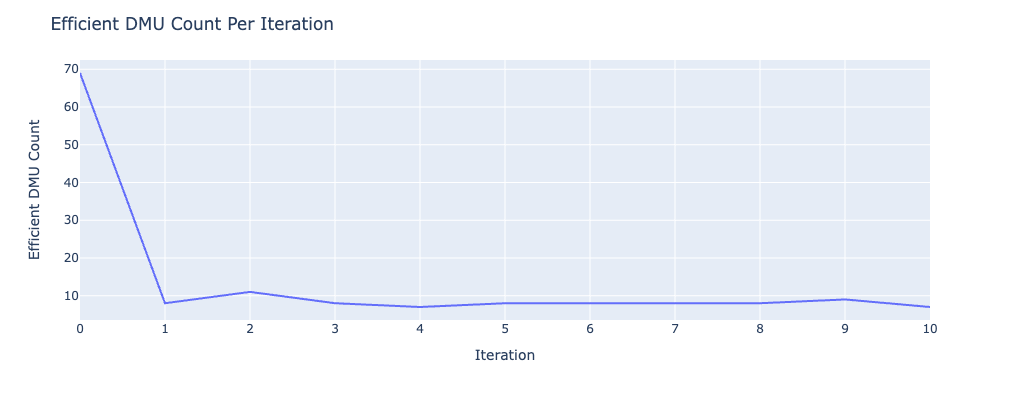

In [19]:
fig = px.line(eDMU, x="Iteration", y="Count")

fig.update_layout(
    autosize=False,
    width=700,
    height=400,
    title_text = "Efficient DMU Count Per Iteration",
    yaxis_title="Efficient DMU Count",)


fig.show()

In [20]:
df_es

0         1         2         3         4         5  \
DMU 0001  0.501907  0.452396  0.427745  0.428969  0.424925  0.423148   
DMU 0002  0.791705  0.614890  0.615526  0.613282  0.614461  0.604989   
DMU 0003  0.565044  0.531879  0.543690  0.528545  0.517561  0.513725   
DMU 0004  0.860990  0.736800  0.734761  0.734761  0.734761  0.734761   
DMU 0005  0.701855  0.655633  0.648628  0.635317  0.636671  0.636260   
...            ...       ...       ...       ...       ...       ...   
DMU 0996  0.670301  0.602185  0.557580  0.531289  0.517400  0.517400   
DMU 0997  0.741442  0.625057  0.605462  0.599461  0.600758  0.585239   
DMU 0998  0.622777  0.561999  0.568780  0.565286  0.564403  0.561125   
DMU 0999  0.748878  0.678913  0.688266  0.668289  0.668289  0.668289   
DMU 1000  0.790059  0.684670  0.669744  0.672742  0.672742  0.672742   

                 6         7         8         9        10  
DMU 0001  0.410686  0.416072  0.423206  0.416072  0.423206  
DMU 0002  0.589056  0.604989  0.599338  0.604989  0.599338  
DMU 0003  0.511266  0.513725  0.512270  0.513725  0.513569  
DMU 0004  0.734761  0.734761  0.734761  0.734761  0.734761  
DMU 0005  0.632324  0.636260  0.636766  0.636260  0.635141  
...            ...       ...       ...       ...       ...  
DMU 0996  0.517400  0.517400  0.517400  0.517400  0.517400  
DMU 0997  0.576470  0.585053  0.584307  0.585053  0.584307  
DMU 0998  0.552356  0.561329  0.555840  0.561125  0.555840  
DMU 0999  0.668289  0.668289  0.668289  0.668289  0.668289  
DMU 1000  0.659119  0.667116  0.672742  0.667116  0.672742  

[1000 rows x 11 columns]

In [21]:
import glob
pattern = "../**/*.ipynb"
query = 'px.box'
for filepath in glob.iglob(pattern, recursive=True):
    with open(filepath) as file:
        s = file.read()
        if (s.find(query) > -1):
            print(filepath)

../DEA/DEA_ML_12I_1O_GB_Realdata_Recurcive_Results.ipynb
../DEA/DEA_miner/DEA_ML_12I_1O_GB_Recurcive_Results_100_0.ipynb
../DEA/DEA_miner/DEA_ML_12I_1O_GB_Recurcive_Results_100.ipynb


In [25]:
df_melted = pd.melt(df_es)
df_melted.columns = ["Iteration", "ES"]

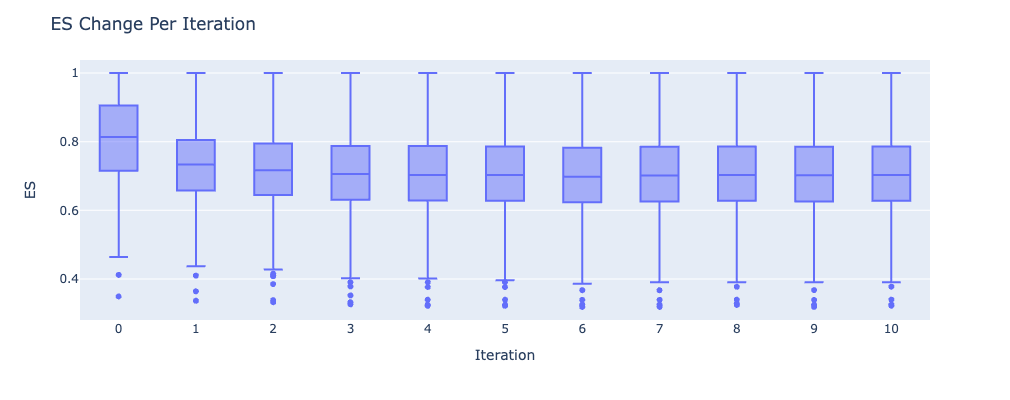

In [27]:
fig = px.box(df_melted, x = "Iteration", y = "ES")

fig.update_layout(
    autosize=False,
    width=1200,
    height=400,
    title_text=f"ES Change Per Iteration"
)

fig .show()